**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import albumentations as A
import tqdm
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [3]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        
        sample['image'] = self.transform(sample['image']).float()
        sample['image'] = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(sample['image'])
        
        sample['mask'] = self.transform(sample['mask']).float()
        return sample

In [4]:
X_train = get_paths("data/train/images")
y_train = get_paths("data/train/gt")
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomCrop(368, 368),
    A.Resize(370, 370),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RGBShift(r_shift_limit=10/255, g_shift_limit=10/255, b_shift_limit=10/255, p=0.5),
])

train_transform = transforms.Compose([
    transforms.ToTensor(),
])


X_test = get_paths("data/test/images")
y_test = get_paths("data/test/gt")
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
train_dataset = RoadDataset(X_train, y_train, train_transform, aug=train_aug)
test_dataset = RoadDataset(X_test, y_test, test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


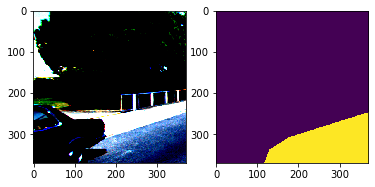

In [6]:
sample = train_dataset[4]
image = sample['image']
mask = sample['mask']

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0)[...,0])

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [7]:
print(f"Train Dataset length {len(train_dataset)}")
print(f"Test Dataset length {len(test_dataset)}")

Train Dataset length 648
Test Dataset length 219


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [8]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [9]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]
    return images

In [10]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for sample in data_generator:
            X_batch = sample['image']
            y_batch = sample['mask']
            X_batch = F.pad(X_batch, ((376-370) // 2, (376-370) // 2, (376-370) // 2, (376-370) // 2), 
                            "constant", 0)
            
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            logits = central_crop(logits, 370)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean(calc_iou(y_pred.cpu().numpy(), y_batch.cpu().numpy())))
    return np.mean(accuracy)

            
def train_model(model, optimizer, train_data_generator):
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.4, 0.6])).to(device)
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for sample in tqdm.tqdm(train_data_generator):
        X_batch = sample['image']
        y_batch = sample['mask']
        X_batch = F.pad(X_batch, ((376-370) // 2, (376-370) // 2, (376-370) // 2, (376-370) // 2), 
                        "constant", 0)
        
        X_batch = X_batch.to(device)
        y_batch = torch.squeeze(y_batch, 1).to(device, dtype=torch.long) 
        predictions = central_crop(model(X_batch), 370)
        
        loss = criterion(predictions, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, 
               epochs_for_lr_decay=[], num_epochs=1):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()
        
        if epoch in epochs_for_lr_decay:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] / 10
        
        train_loss = train_model(model, optimizer, train_data_generator)  
        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation iou: \t\t\t{:.3f} ".format(val_accuracy))

In [11]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class=2):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 16)
        self.dconv_down2 = double_conv(16, 32)
        self.dconv_down3 = double_conv(32, 64)
        self.dconv_down4 = double_conv(64, 128)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(64 + 128, 64)
        self.dconv_up2 = double_conv(32 + 64, 32)
        self.dconv_up1 = double_conv(32 + 16, 16)
        
        self.conv_last = nn.Conv2d(16, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

# Training UNET from scratch

In [12]:
unet = UNet().to(device)
optimizer = torch.optim.Adam(unet.parameters(), weight_decay=1e-5)

batch_size = 12
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)

test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=4)

In [13]:
train_loop(unet, optimizer, train_batch_gen, test_batch_gen, epochs_for_lr_decay=[60, 80], num_epochs=90)

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1 of 90 took 51.784s
  training loss (in-iteration): 	0.365818
  validation iou: 			0.537 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2 of 90 took 52.137s
  training loss (in-iteration): 	0.282776
  validation iou: 			0.547 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3 of 90 took 52.221s
  training loss (in-iteration): 	0.254081
  validation iou: 			0.479 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4 of 90 took 52.812s
  training loss (in-iteration): 	0.233755
  validation iou: 			0.586 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5 of 90 took 52.968s
  training loss (in-iteration): 	0.241022
  validation iou: 			0.581 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6 of 90 took 52.673s
  training loss (in-iteration): 	0.225047
  validation iou: 			0.596 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7 of 90 took 52.104s
  training loss (in-iteration): 	0.212309
  validation iou: 			0.588 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8 of 90 took 52.421s
  training loss (in-iteration): 	0.201219
  validation iou: 			0.582 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9 of 90 took 52.246s
  training loss (in-iteration): 	0.200998
  validation iou: 			0.578 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10 of 90 took 52.212s
  training loss (in-iteration): 	0.208789
  validation iou: 			0.587 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11 of 90 took 52.228s
  training loss (in-iteration): 	0.201700
  validation iou: 			0.606 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12 of 90 took 52.380s
  training loss (in-iteration): 	0.185440
  validation iou: 			0.614 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13 of 90 took 52.940s
  training loss (in-iteration): 	0.183685
  validation iou: 			0.628 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14 of 90 took 52.014s
  training loss (in-iteration): 	0.175083
  validation iou: 			0.611 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15 of 90 took 52.172s
  training loss (in-iteration): 	0.188281
  validation iou: 			0.629 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16 of 90 took 52.447s
  training loss (in-iteration): 	0.170147
  validation iou: 			0.629 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17 of 90 took 52.558s
  training loss (in-iteration): 	0.169130
  validation iou: 			0.605 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18 of 90 took 52.149s
  training loss (in-iteration): 	0.177464
  validation iou: 			0.613 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19 of 90 took 52.620s
  training loss (in-iteration): 	0.165643
  validation iou: 			0.644 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20 of 90 took 52.386s
  training loss (in-iteration): 	0.154499
  validation iou: 			0.660 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 21 of 90 took 52.310s
  training loss (in-iteration): 	0.172164
  validation iou: 			0.545 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 22 of 90 took 52.448s
  training loss (in-iteration): 	0.156867
  validation iou: 			0.654 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 23 of 90 took 52.469s
  training loss (in-iteration): 	0.153755
  validation iou: 			0.626 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 24 of 90 took 53.073s
  training loss (in-iteration): 	0.149744
  validation iou: 			0.615 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 25 of 90 took 53.138s
  training loss (in-iteration): 	0.164341
  validation iou: 			0.647 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 26 of 90 took 53.014s
  training loss (in-iteration): 	0.162893
  validation iou: 			0.601 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 27 of 90 took 52.162s
  training loss (in-iteration): 	0.155075
  validation iou: 			0.665 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 28 of 90 took 53.302s
  training loss (in-iteration): 	0.140397
  validation iou: 			0.696 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 29 of 90 took 53.552s
  training loss (in-iteration): 	0.142901
  validation iou: 			0.663 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 30 of 90 took 53.936s
  training loss (in-iteration): 	0.141379
  validation iou: 			0.681 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 31 of 90 took 53.383s
  training loss (in-iteration): 	0.135614
  validation iou: 			0.669 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 32 of 90 took 53.910s
  training loss (in-iteration): 	0.140186
  validation iou: 			0.656 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 33 of 90 took 53.833s
  training loss (in-iteration): 	0.136889
  validation iou: 			0.702 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 34 of 90 took 54.173s
  training loss (in-iteration): 	0.126850
  validation iou: 			0.696 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 35 of 90 took 53.042s
  training loss (in-iteration): 	0.141243
  validation iou: 			0.697 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 36 of 90 took 53.923s
  training loss (in-iteration): 	0.115210
  validation iou: 			0.713 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 37 of 90 took 53.409s
  training loss (in-iteration): 	0.125988
  validation iou: 			0.688 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 38 of 90 took 53.386s
  training loss (in-iteration): 	0.122558
  validation iou: 			0.662 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 39 of 90 took 53.461s
  training loss (in-iteration): 	0.133475
  validation iou: 			0.689 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 40 of 90 took 54.055s
  training loss (in-iteration): 	0.120664
  validation iou: 			0.697 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 41 of 90 took 54.017s
  training loss (in-iteration): 	0.124532
  validation iou: 			0.669 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 42 of 90 took 52.959s
  training loss (in-iteration): 	0.120003
  validation iou: 			0.688 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 43 of 90 took 52.922s
  training loss (in-iteration): 	0.116065
  validation iou: 			0.694 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 44 of 90 took 52.546s
  training loss (in-iteration): 	0.120186
  validation iou: 			0.679 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 45 of 90 took 53.629s
  training loss (in-iteration): 	0.119847
  validation iou: 			0.669 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 46 of 90 took 53.046s
  training loss (in-iteration): 	0.116749
  validation iou: 			0.685 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 47 of 90 took 53.891s
  training loss (in-iteration): 	0.114942
  validation iou: 			0.679 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 48 of 90 took 54.041s
  training loss (in-iteration): 	0.112595
  validation iou: 			0.690 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 49 of 90 took 53.001s
  training loss (in-iteration): 	0.114472
  validation iou: 			0.730 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 50 of 90 took 52.988s
  training loss (in-iteration): 	0.113825
  validation iou: 			0.730 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 51 of 90 took 53.009s
  training loss (in-iteration): 	0.104201
  validation iou: 			0.737 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 52 of 90 took 52.492s
  training loss (in-iteration): 	0.107361
  validation iou: 			0.714 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 53 of 90 took 52.480s
  training loss (in-iteration): 	0.105891
  validation iou: 			0.699 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 54 of 90 took 52.677s
  training loss (in-iteration): 	0.102906
  validation iou: 			0.696 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 55 of 90 took 52.597s
  training loss (in-iteration): 	0.099084
  validation iou: 			0.717 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 56 of 90 took 52.553s
  training loss (in-iteration): 	0.096874
  validation iou: 			0.698 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 57 of 90 took 52.995s
  training loss (in-iteration): 	0.093189
  validation iou: 			0.717 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 58 of 90 took 52.703s
  training loss (in-iteration): 	0.105539
  validation iou: 			0.685 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 59 of 90 took 52.749s
  training loss (in-iteration): 	0.102348
  validation iou: 			0.728 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 60 of 90 took 52.766s
  training loss (in-iteration): 	0.095144
  validation iou: 			0.741 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 61 of 90 took 52.627s
  training loss (in-iteration): 	0.083388
  validation iou: 			0.758 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 62 of 90 took 52.919s
  training loss (in-iteration): 	0.081904
  validation iou: 			0.768 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 63 of 90 took 52.572s
  training loss (in-iteration): 	0.076396
  validation iou: 			0.759 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 64 of 90 took 52.889s
  training loss (in-iteration): 	0.076497
  validation iou: 			0.762 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 65 of 90 took 53.251s
  training loss (in-iteration): 	0.078027
  validation iou: 			0.755 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 66 of 90 took 52.881s
  training loss (in-iteration): 	0.079447
  validation iou: 			0.767 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 67 of 90 took 52.854s
  training loss (in-iteration): 	0.076325
  validation iou: 			0.759 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 68 of 90 took 52.960s
  training loss (in-iteration): 	0.076940
  validation iou: 			0.753 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 69 of 90 took 52.803s
  training loss (in-iteration): 	0.075880
  validation iou: 			0.767 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 70 of 90 took 53.056s
  training loss (in-iteration): 	0.075826
  validation iou: 			0.767 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 71 of 90 took 52.842s
  training loss (in-iteration): 	0.075315
  validation iou: 			0.753 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 72 of 90 took 52.793s
  training loss (in-iteration): 	0.075179
  validation iou: 			0.764 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 73 of 90 took 53.108s
  training loss (in-iteration): 	0.073919
  validation iou: 			0.764 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 74 of 90 took 53.028s
  training loss (in-iteration): 	0.072374
  validation iou: 			0.765 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 75 of 90 took 53.036s
  training loss (in-iteration): 	0.071128
  validation iou: 			0.767 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 76 of 90 took 52.785s
  training loss (in-iteration): 	0.071661
  validation iou: 			0.776 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 77 of 90 took 52.337s
  training loss (in-iteration): 	0.072039
  validation iou: 			0.765 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 78 of 90 took 52.928s
  training loss (in-iteration): 	0.073023
  validation iou: 			0.766 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 79 of 90 took 52.604s
  training loss (in-iteration): 	0.072061
  validation iou: 			0.777 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 80 of 90 took 52.746s
  training loss (in-iteration): 	0.071854
  validation iou: 			0.767 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 81 of 90 took 53.107s
  training loss (in-iteration): 	0.070478
  validation iou: 			0.769 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 82 of 90 took 53.496s
  training loss (in-iteration): 	0.070378
  validation iou: 			0.767 


100%|██████████| 54/54 [00:49<00:00,  1.08it/s]


Epoch 83 of 90 took 940.972s
  training loss (in-iteration): 	0.070258
  validation iou: 			0.768 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 84 of 90 took 207.873s
  training loss (in-iteration): 	0.069542
  validation iou: 			0.772 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 85 of 90 took 54.867s
  training loss (in-iteration): 	0.070158
  validation iou: 			0.770 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 86 of 90 took 51.679s
  training loss (in-iteration): 	0.067816
  validation iou: 			0.771 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 87 of 90 took 52.088s
  training loss (in-iteration): 	0.066891
  validation iou: 			0.768 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 88 of 90 took 51.992s
  training loss (in-iteration): 	0.067127
  validation iou: 			0.770 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 89 of 90 took 52.255s
  training loss (in-iteration): 	0.067434
  validation iou: 			0.768 


100%|██████████| 54/54 [00:48<00:00,  1.12it/s]


Epoch 90 of 90 took 52.419s
  training loss (in-iteration): 	0.068777
  validation iou: 			0.770 


In [14]:
val_accuracy = eval_model(unet, test_batch_gen)
print("Final test iou for unet: \t\t\t{:.3f} ".format(val_accuracy))

Final test iou for unet: 			0.770 


# Training using pretrained classifier

In [15]:
class ResNetBlock(nn.Module):
    def __init__(self, ich, outch):
        super().__init__()
        self.conv1 = nn.Conv2d(ich, outch, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(outch)
        self.conv2 = nn.Conv2d(outch, outch, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(outch)
        self.relu = nn.ReLU()
        self.skip = nn.Conv2d(ich, outch, 1)
        
    def forward(self, x):
        skip = self.skip(x)
        x = self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x)))))
        return self.relu(x + skip)
        

class SegResNet(nn.Module):

    def __init__(self, n_class=2):
        super().__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(resnet18.conv1,resnet18.bn1, resnet18.relu, 
                        resnet18.maxpool, resnet18.layer1, resnet18.layer2, resnet18.layer3)
                       
        self.upsample = nn.PixelShuffle(2)
        self.res0 = ResNetBlock(256, 256)
        self.res1 = ResNetBlock(64, 128)
        self.res2 = ResNetBlock(32, 128)
        self.res3 = ResNetBlock(32, 128)
        self.res4 = ResNetBlock(32, 16)
        self.conv_last = nn.Conv2d(16, n_class, 1)
        self.decoder = nn.Sequential(self.res0, self.upsample, self.res1, self.upsample, self.res2,
                                     self.upsample, self.res3, self.upsample, self.res4)
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return self.conv_last(x)

In [16]:
torch.cuda.empty_cache()

batch_size = 8
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)

test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=4)

In [17]:
seg_resnet = SegResNet().to(device)
optimizer = torch.optim.Adam([
        {'params': seg_resnet.decoder.parameters()},
        {'params': seg_resnet.conv_last.parameters()},
        {'params': seg_resnet.encoder.parameters(), 'lr': 1e-4}
    ], lr=1e-3, weight_decay=1e-4)

In [18]:
train_loop(seg_resnet, optimizer, train_batch_gen, test_batch_gen, epochs_for_lr_decay=[30,40], num_epochs=50)

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 1 of 50 took 93.337s
  training loss (in-iteration): 	0.229049
  validation iou: 			0.697 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 2 of 50 took 66.606s
  training loss (in-iteration): 	0.122689
  validation iou: 			0.727 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 3 of 50 took 66.925s
  training loss (in-iteration): 	0.096233
  validation iou: 			0.799 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 4 of 50 took 66.355s
  training loss (in-iteration): 	0.088385
  validation iou: 			0.821 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 5 of 50 took 65.890s
  training loss (in-iteration): 	0.078303
  validation iou: 			0.802 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 6 of 50 took 64.475s
  training loss (in-iteration): 	0.066994
  validation iou: 			0.778 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 7 of 50 took 64.324s
  training loss (in-iteration): 	0.059324
  validation iou: 			0.827 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 8 of 50 took 64.224s
  training loss (in-iteration): 	0.056504
  validation iou: 			0.801 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 9 of 50 took 64.146s
  training loss (in-iteration): 	0.054047
  validation iou: 			0.832 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 10 of 50 took 63.827s
  training loss (in-iteration): 	0.047976
  validation iou: 			0.818 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 11 of 50 took 64.175s
  training loss (in-iteration): 	0.046710
  validation iou: 			0.836 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 12 of 50 took 63.926s
  training loss (in-iteration): 	0.047339
  validation iou: 			0.849 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 13 of 50 took 64.244s
  training loss (in-iteration): 	0.039245
  validation iou: 			0.808 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 14 of 50 took 64.892s
  training loss (in-iteration): 	0.044409
  validation iou: 			0.842 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 15 of 50 took 65.081s
  training loss (in-iteration): 	0.037394
  validation iou: 			0.814 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 16 of 50 took 65.061s
  training loss (in-iteration): 	0.045620
  validation iou: 			0.801 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 17 of 50 took 64.730s
  training loss (in-iteration): 	0.041173
  validation iou: 			0.787 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 18 of 50 took 64.679s
  training loss (in-iteration): 	0.040206
  validation iou: 			0.827 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 19 of 50 took 65.683s
  training loss (in-iteration): 	0.039195
  validation iou: 			0.856 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 20 of 50 took 64.874s
  training loss (in-iteration): 	0.033999
  validation iou: 			0.825 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 21 of 50 took 64.537s
  training loss (in-iteration): 	0.037990
  validation iou: 			0.841 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 22 of 50 took 64.527s
  training loss (in-iteration): 	0.034692
  validation iou: 			0.804 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 23 of 50 took 64.725s
  training loss (in-iteration): 	0.032820
  validation iou: 			0.836 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 24 of 50 took 64.324s
  training loss (in-iteration): 	0.036983
  validation iou: 			0.831 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 25 of 50 took 63.710s
  training loss (in-iteration): 	0.030385
  validation iou: 			0.857 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 26 of 50 took 63.624s
  training loss (in-iteration): 	0.030782
  validation iou: 			0.855 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 27 of 50 took 63.494s
  training loss (in-iteration): 	0.029749
  validation iou: 			0.850 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 28 of 50 took 63.433s
  training loss (in-iteration): 	0.027511
  validation iou: 			0.862 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 29 of 50 took 63.516s
  training loss (in-iteration): 	0.031994
  validation iou: 			0.861 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 30 of 50 took 63.482s
  training loss (in-iteration): 	0.030408
  validation iou: 			0.802 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 31 of 50 took 63.418s
  training loss (in-iteration): 	0.026129
  validation iou: 			0.869 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 32 of 50 took 63.581s
  training loss (in-iteration): 	0.023613
  validation iou: 			0.874 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 33 of 50 took 63.471s
  training loss (in-iteration): 	0.023693
  validation iou: 			0.870 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 34 of 50 took 63.617s
  training loss (in-iteration): 	0.022759
  validation iou: 			0.875 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 35 of 50 took 63.613s
  training loss (in-iteration): 	0.022566
  validation iou: 			0.876 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 36 of 50 took 64.232s
  training loss (in-iteration): 	0.021871
  validation iou: 			0.878 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 37 of 50 took 64.591s
  training loss (in-iteration): 	0.020730
  validation iou: 			0.879 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 38 of 50 took 63.812s
  training loss (in-iteration): 	0.022038
  validation iou: 			0.878 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 39 of 50 took 63.466s
  training loss (in-iteration): 	0.021235
  validation iou: 			0.876 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 40 of 50 took 63.828s
  training loss (in-iteration): 	0.021141
  validation iou: 			0.877 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 41 of 50 took 63.476s
  training loss (in-iteration): 	0.020745
  validation iou: 			0.878 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 42 of 50 took 63.873s
  training loss (in-iteration): 	0.020888
  validation iou: 			0.878 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 43 of 50 took 63.326s
  training loss (in-iteration): 	0.020035
  validation iou: 			0.877 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 44 of 50 took 63.273s
  training loss (in-iteration): 	0.019940
  validation iou: 			0.878 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 45 of 50 took 63.569s
  training loss (in-iteration): 	0.020273
  validation iou: 			0.878 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 46 of 50 took 63.765s
  training loss (in-iteration): 	0.020773
  validation iou: 			0.878 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 47 of 50 took 63.480s
  training loss (in-iteration): 	0.020692
  validation iou: 			0.879 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 48 of 50 took 63.665s
  training loss (in-iteration): 	0.021054
  validation iou: 			0.878 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 49 of 50 took 63.608s
  training loss (in-iteration): 	0.020326
  validation iou: 			0.879 


100%|██████████| 81/81 [00:56<00:00,  1.43it/s]


Epoch 50 of 50 took 63.523s
  training loss (in-iteration): 	0.019570
  validation iou: 			0.879 


In [19]:
val_accuracy = eval_model(seg_resnet, test_batch_gen)

print("Final test iou for cnn with pretrained classifier: \t\t\t{:.3f} ".format(val_accuracy))

Final test iou for cnn with pretrained classifier: 			0.879 
